**Curious about how I uncovered these 3 customer clusters from the original dataset? You’ll find all the details in this notebook and on my portfolio site :** https://www.pierregraef.com/projects/customer-analysis

![](http://www.pierregraef.com/_vercel/image?url=%2Fimg%2Farticle_customer%2FClusterAnalysisV2.png&w=1536&q=100)

# Import librairies & Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [3]:
df_cust = pd.read_csv('marketing_campaign.csv',sep="\t")
df_cust

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


# Exploratory Data Analysis

In [4]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

The Income column has 24 missing values out of 2240 rows

### Handling missing value

In [5]:
median_income = df_cust['Income'].median()
df_cust.loc[:, 'Income'] = df_cust['Income'].fillna(median_income)

### Age Distribution

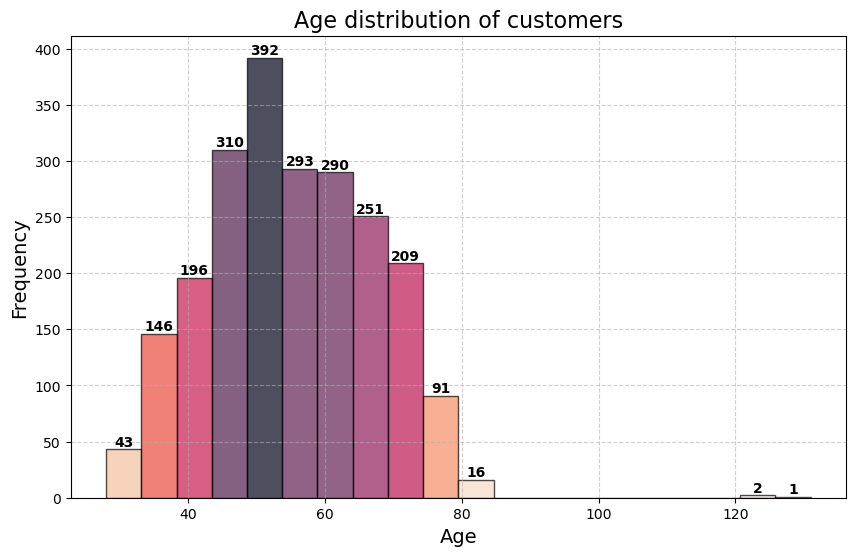

In [6]:
df_cust['Age'] = 2024 - df_cust['Year_Birth']

plt.figure(figsize=(10, 6))

# Normalize color by the bar height
n, bins, patches = plt.hist(df_cust['Age'], bins=20, color='blue', alpha=0.7, edgecolor='black')
for i in range(len(patches)):
    patches[i].set_facecolor(sns.color_palette("rocket_r", as_cmap=True)(n[i] / max(n)))
    if n[i] > 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], int(n[i]), 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Age distribution of customers', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The age distribution shows that the majority of customers are aged between 40 and 65, with a peak at around 50 years old. There are very few customers older than 80, and a small number of outliers over 100, which may indicate data entry errors or anomalies.

### Remove outliers

In [8]:
df_cust = df_cust[(df_cust['Income'] <= 300000) & (df_cust['Age'] <= 90)]

### Income Distribution

In [9]:
total_customers = len(df_cust['Income'].dropna())
high_income_customers = len(df_cust[df_cust['Income'] > 100000])
percentage_high_income = (high_income_customers / total_customers) * 100

print(f"Percentage of customers with income supérior to 100,000: {percentage_high_income:.2f}%")

Percentage of customers with income supérior to 100,000: 0.54%


So we're not going to include these outliers in order to have a closer look on the income distribution between 0 and 100 000.

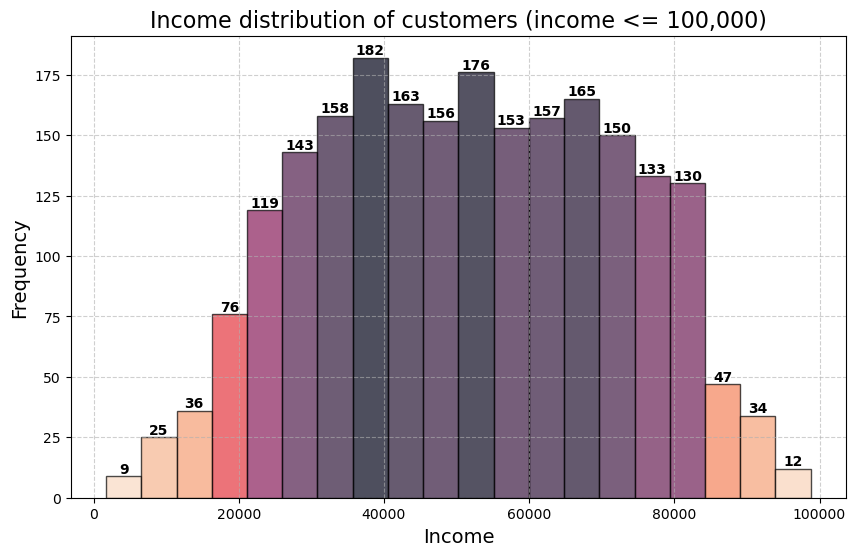

In [10]:
df_cust_filtered = df_cust[df_cust['Income'] <= 100000]

plt.figure(figsize=(10, 6))

n, bins, patches = plt.hist(df_cust_filtered['Income'].dropna(), bins=20, color='blue', alpha=0.7, edgecolor='black')
for i in range(len(patches)):
    patches[i].set_facecolor(sns.color_palette("rocket_r", as_cmap=True)(n[i] / max(n)))
    if n[i] > 0:
        plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], int(n[i]), 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Income distribution of customers (income <= 100,000)', fontsize=16)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

### Spending Patterns on Products

We will analyze how much customers spend across various product categories

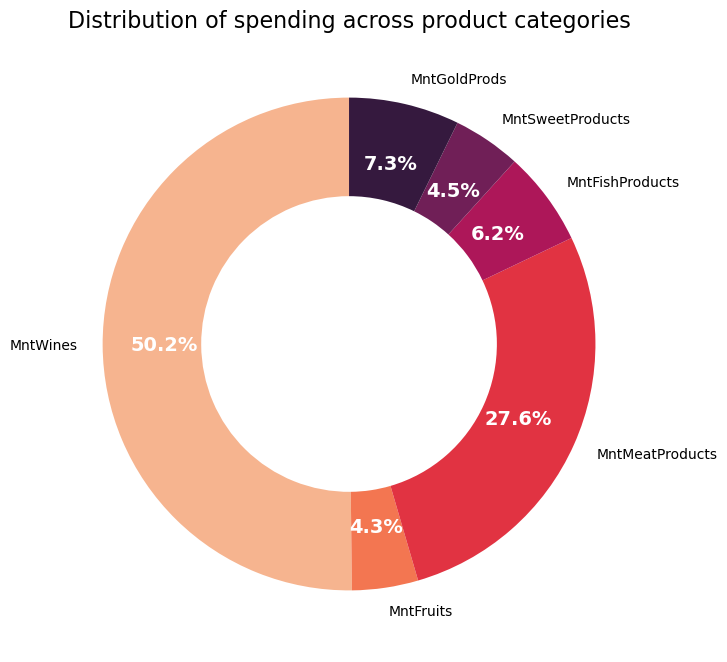

In [11]:
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
total_spend = df_cust[product_columns].sum()


colors = sns.color_palette("rocket_r", len(product_columns))
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(total_spend, labels=product_columns, autopct='%1.1f%%', 
                                   startangle=90, colors=colors, wedgeprops=dict(width=0.4), pctdistance=0.75)
for autotext in autotexts:
    autotext.set_color('white')  # white for better contrast
    autotext.set_fontsize(14)    
    autotext.set_weight('bold')  

# Add title
plt.title('Distribution of spending across product categories', fontsize=16)

plt.show()


### Spending by marital status

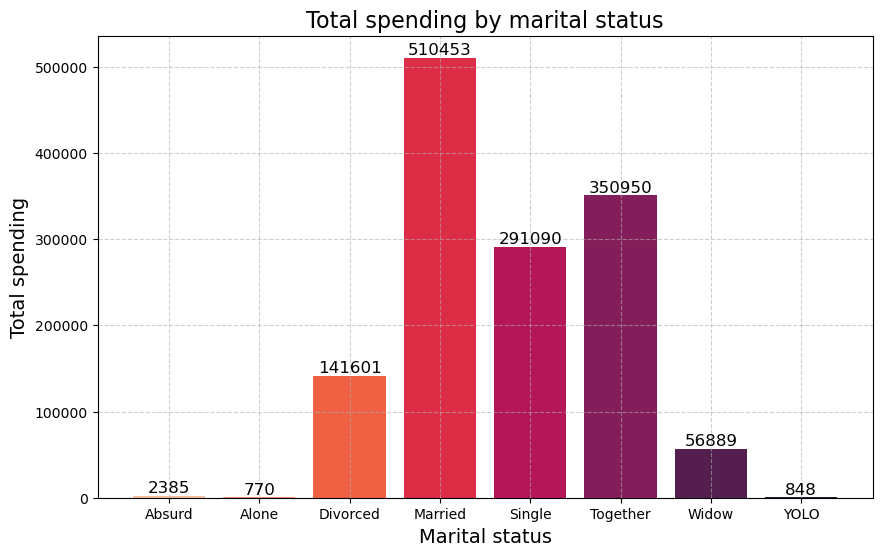

In [12]:
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_cust['Total_Spend'] = df_cust[product_columns].sum(axis=1)

spending_by_marital_status = df_cust.groupby('Marital_Status')['Total_Spend'].sum()
norm = spending_by_marital_status / spending_by_marital_status.max()

plt.figure(figsize=(10, 6))
bars = plt.bar(spending_by_marital_status.index, spending_by_marital_status, 
               color=sns.color_palette("rocket_r", len(spending_by_marital_status)))

for bar, spend in zip(bars, spending_by_marital_status):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(spend)}', ha='center', va='bottom', fontsize=12)

plt.title('Total spending by marital status', fontsize=16)
plt.xlabel('Marital status', fontsize=14)
plt.ylabel('Total spending', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Preprocessing data (encoding, feature engineering...)

## Encode columns Education and Marital_Status

In [13]:
le = LabelEncoder()

df_cust['Education'] = le.fit_transform(df_cust['Education'])
df_cust['Marital_Status'] = le.fit_transform(df_cust['Marital_Status'])

In [14]:
df_cust.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Total_Spend
0,5524,1957,2,4,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,3,11,1,67,1617
1,2174,1954,2,4,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,3,11,0,70,27
2,4141,1965,2,5,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,3,11,0,59,776
3,6182,1984,2,5,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,3,11,0,40,53
4,5324,1981,4,3,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,3,11,0,43,422


### Correlations

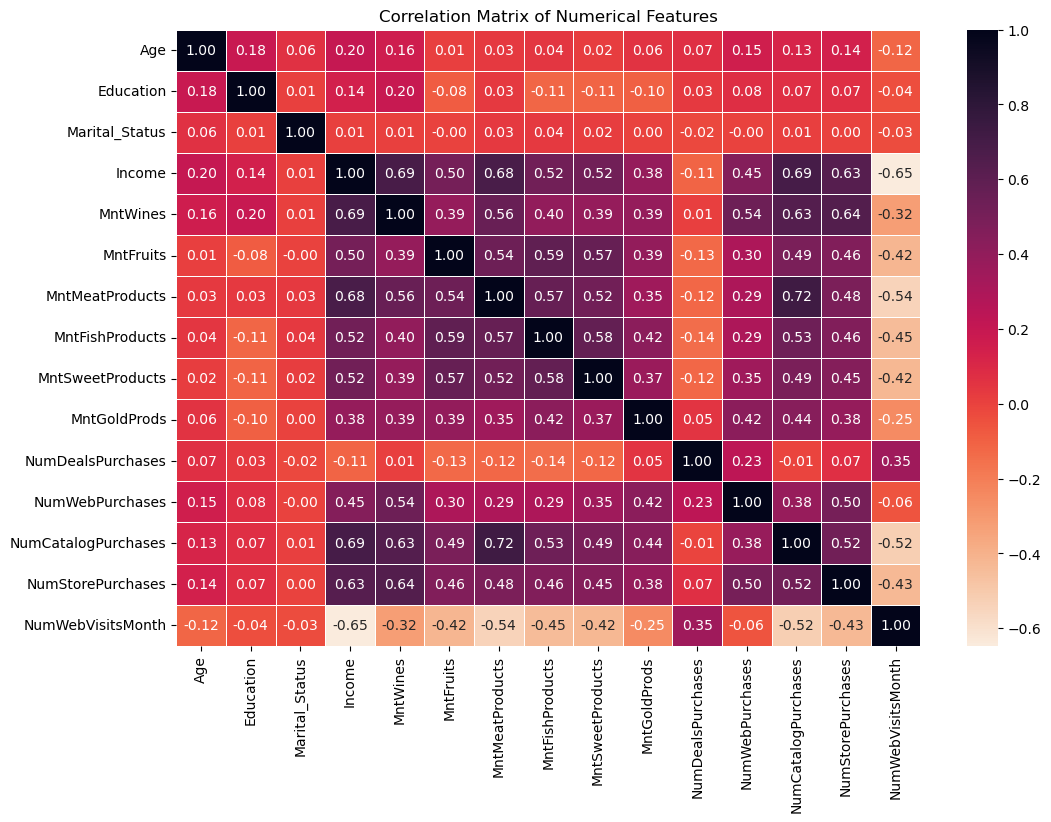

In [15]:
numerical_cols = ['Age', 'Education', 'Marital_Status', 'Income', 'MntWines', 
                  'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                  'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
                  'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 
                  'NumWebVisitsMonth']

corr_matrix = df_cust[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='rocket_r', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Exemple of insights : 

NumDealsPurchases and Income (-0.08): This slightly negative correlation shows that higher-income customers tend to be less interested in purchasing via discounts, possibly indicating price insensitivity

## Feature engineering

Fex examples of useful features created

In [16]:
df_cust['Family_Size'] = df_cust['Kidhome'] + df_cust['Teenhome']

In [17]:
df_cust['Avg_Spend_Per_Purchase'] = df_cust['Total_Spend'] / (df_cust['NumDealsPurchases'] + df_cust['NumWebPurchases'] + 
                                                    df_cust['NumCatalogPurchases'] + df_cust['NumStorePurchases'])

In [18]:
df_cust['Wine_Ratio'] = df_cust['MntWines'] / df_cust['Total_Spend']
df_cust['Meat_Ratio'] = df_cust['MntMeatProducts'] / df_cust['Total_Spend']
df_cust['Fruit_Ratio'] = df_cust['MntFruits'] / df_cust['Total_Spend']

In [19]:
df_cust['Total_Accepted_Campaigns'] = (df_cust['AcceptedCmp1'] + df_cust['AcceptedCmp2'] + 
                                  df_cust['AcceptedCmp3'] + df_cust['AcceptedCmp4'] + df_cust['AcceptedCmp5'])

<Figure size 800x600 with 0 Axes>

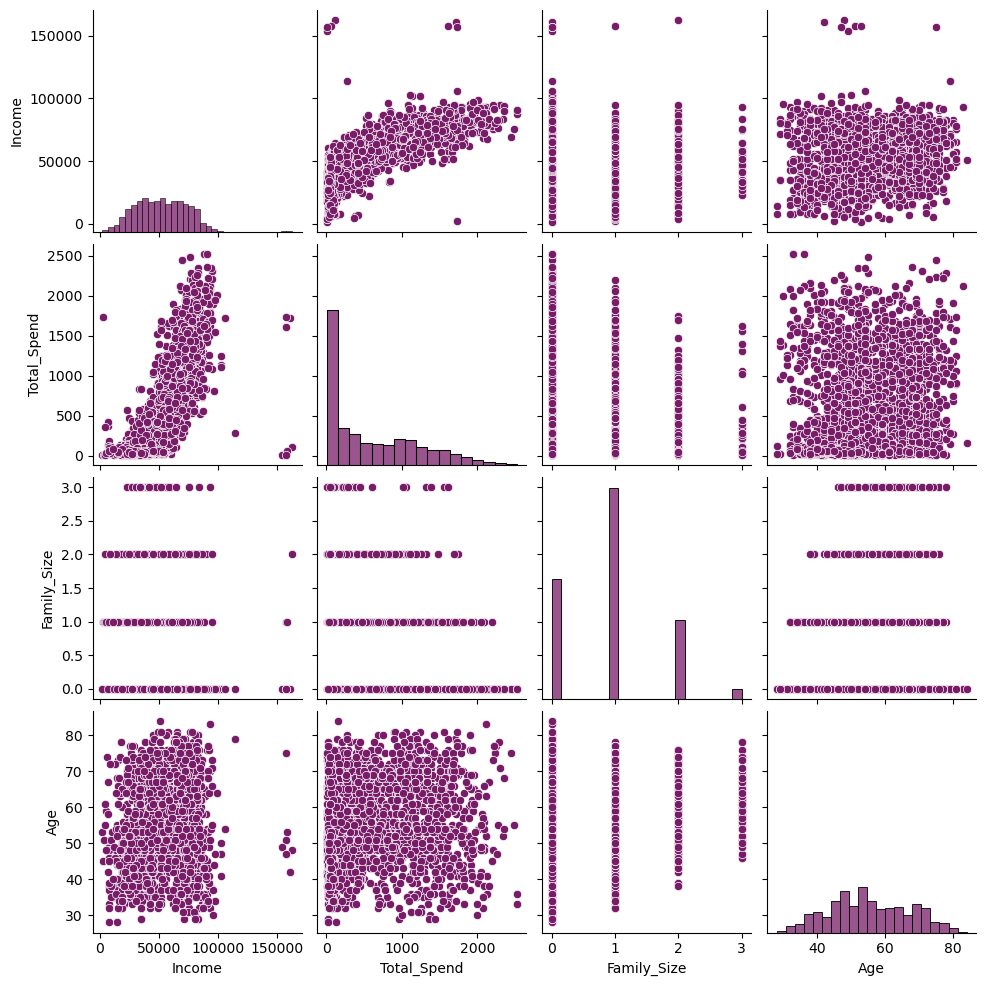

In [20]:
plt.figure(figsize=(8, 6))
sns.pairplot(df_cust[['Income', 'Total_Spend', 'Family_Size', 'Age']],
             plot_kws={'color': '#781C68'},
             diag_kws={'color': '#781C68', 'fill': True}) 
plt.show()

# Clustering

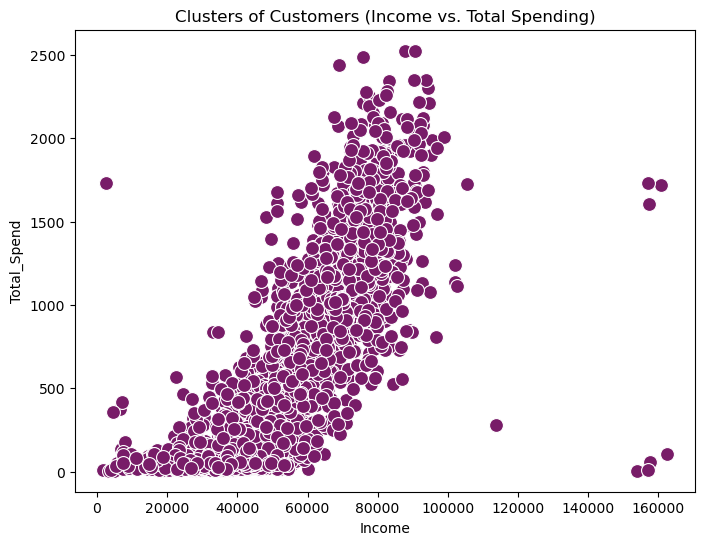

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income', y='Total_Spend', data=df_cust, s=100, color='#781C68') 
plt.title('Clusters of Customers (Income vs. Total Spending)')
plt.show()

In [22]:
# Features for clustering
features = ['Income', 'Total_Spend', 'Age', 'Family_Size']

# Scaling the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cust[features])

# Convert the scaled data back to a DataFrame (optional, for easy manipulation)
scaled_df = pd.DataFrame(scaled_features, columns=features)

## Elbow Method for Determining Optimal Clusters
The Elbow Method is a technique used to determine the optimal number of clusters (K) for K-Means clustering. The goal is to choose a K value that minimizes the sum of squared distances between each point and its assigned cluster center, known as the Sum of Squared Errors (SSE).

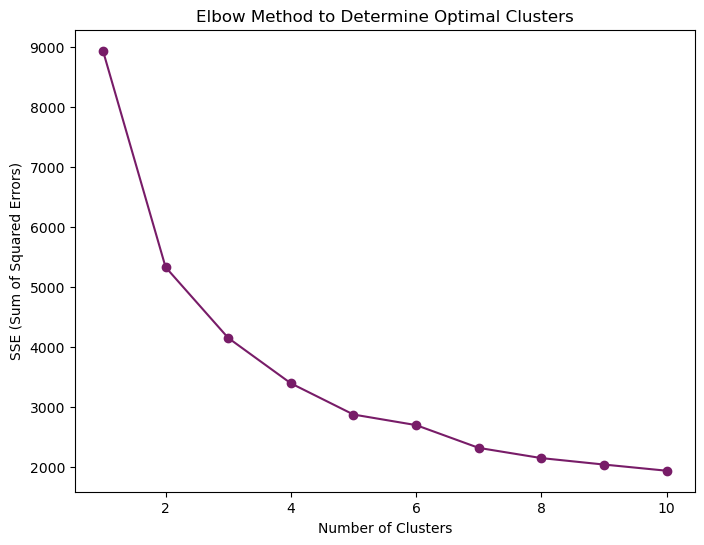

In [23]:
# Elbow Method to find the optimal number of clusters
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)

# plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', color='#781C68')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

Elbow Method suggests 3 or 4 clusters

## K-means

In [24]:
optimal_clusters = 3

# Running K-Means with the chosen number of (optimal) clusters
kmeans = KMeans(n_clusters=optimal_clusters,n_init=20, random_state=42)
df_cust['Cluster'] = kmeans.fit_predict(scaled_df)

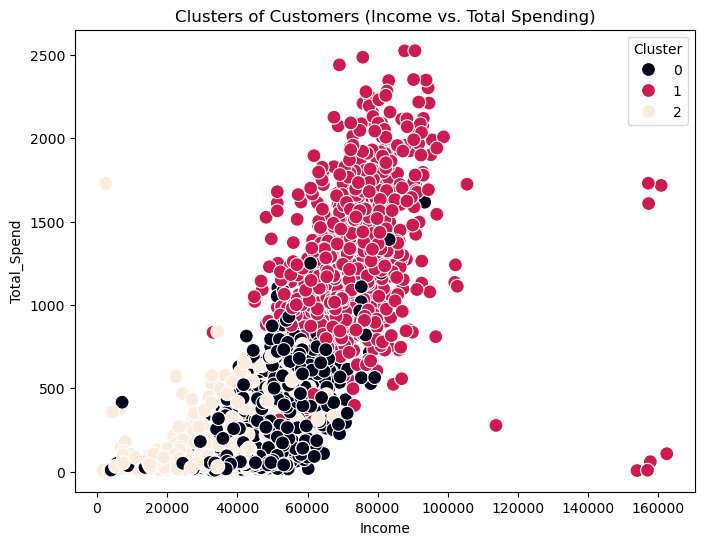

In [25]:
# Scatter plot to visualize the clusters based on Income and Total Spend
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Income', y='Total_Spend', hue='Cluster', data=df_cust, palette='rocket', s=100)
plt.title('Clusters of Customers (Income vs. Total Spending)')
plt.show()


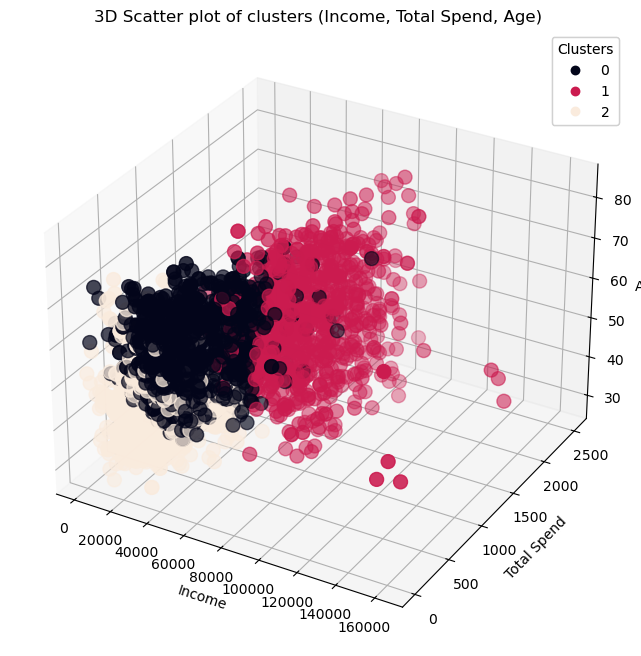

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_cust['Income'], df_cust['Total_Spend'], df_cust['Age'], 
                     c=df_cust['Cluster'], cmap='rocket', s=100)

ax.set_xlabel('Income')
ax.set_ylabel('Total Spend')
ax.set_zlabel('Age')
plt.title('3D Scatter plot of clusters (Income, Total Spend, Age)')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.show()


## t-SNE 
"t-distributed Stochastic Neighbor Embedding" is a powerful machine learning algorithm primarily used for visualizing high-dimensional data by reducing its dimensions to 2 or 3, while preserving the structure and relationships between data points.

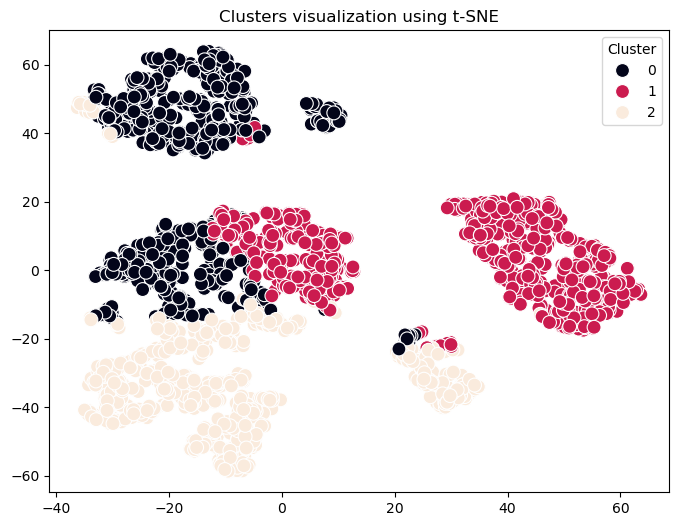

In [27]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_df)

plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1], hue=df_cust['Cluster'], palette='rocket', s=100)
plt.title('Clusters visualization using t-SNE')
plt.show()

## Silhouette & others metrics

In [28]:
silhouette_avg = silhouette_score(scaled_df, df_cust['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.31536297694479876


In [29]:
db_score = davies_bouldin_score(scaled_df, df_cust['Cluster'])
print(f'Davies-Bouldin Index: {db_score}')

Davies-Bouldin Index: 1.1600289706730056


In [30]:
ch_score = calinski_harabasz_score(scaled_df, df_cust['Cluster'])
print(f'Calinski-Harabasz Score: {ch_score}')

Calinski-Harabasz Score: 1286.3875821443255


## Improve K-means with PCA

In [31]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_df)

kmeans_pca = KMeans(n_clusters=optimal_clusters,n_init=20, random_state=42)
df_cust['Cluster_PCA'] = kmeans_pca.fit_predict(pca_features)

In [32]:
silhouette_avg_pca = silhouette_score(pca_features, df_cust['Cluster_PCA'])
db_score_pca = davies_bouldin_score(pca_features, df_cust['Cluster_PCA'])
ch_score_pca = calinski_harabasz_score(pca_features, df_cust['Cluster_PCA'])

print(f'Silhouette Score (PCA): {silhouette_avg_pca}')
print(f'Davies-Bouldin Index (PCA): {db_score_pca}')
print(f'Calinski-Harabasz Score (PCA): {ch_score_pca}')

Silhouette Score (PCA): 0.3966684080747072
Davies-Bouldin Index (PCA): 0.8806367095198961
Calinski-Harabasz Score (PCA): 2133.3912410133867


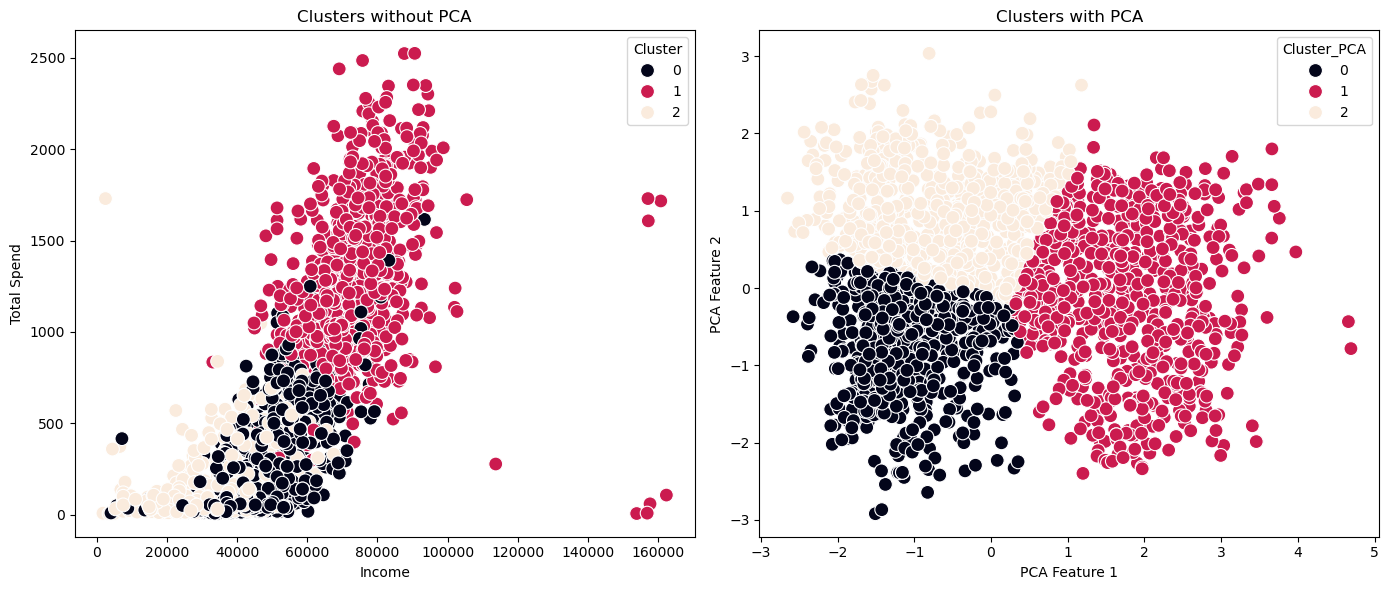

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot without PCA
sns.scatterplot(x='Income', y='Total_Spend', hue='Cluster', data=df_cust, palette='rocket', s=100, ax=ax[0])
ax[0].set_title('Clusters without PCA')
ax[0].set_xlabel('Income')
ax[0].set_ylabel('Total Spend')

# Plot with PCA
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=df_cust['Cluster_PCA'], palette='rocket', s=100, ax=ax[1])
ax[1].set_title('Clusters with PCA')
ax[1].set_xlabel('PCA Feature 1')
ax[1].set_ylabel('PCA Feature 2')

plt.tight_layout()
plt.show()

In [34]:
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by each principal component: {explained_variance}')
print(f'Total variance explained by PCA: {sum(explained_variance)}')


Explained variance by each principal component: [0.53214143 0.27058511]
Total variance explained by PCA: 0.8027265468565185


The first two principal components capture approximately 77% of the total variance in the original data. This means that although some information is lost (about 23%), PCA still retains most of the important variance in the data. This explains why the clustering improved with PCA, as it condensed the data into a lower-dimensional space that is still representative of the original feature set.

### Comparison of Clustering with and without PCA:

#### Silhouette Score:

Without PCA: 0.3047

With PCA: 0.3937

Interpretation: The silhouette score is better after applying PCA, which suggests that the clusters are better separated in the PCA-transformed space. A silhouette score closer to 1 indicates better-defined clusters. The improvement indicates that PCA has likely simplified the relationships between features, making the clusters more distinct.

#### Davies-Bouldin Index:

Without PCA: 1.1934

With PCA: 0.8859

Interpretation: A lower Davies-Bouldin Index after PCA indicates that the clusters are more compact and well-separated. This metric shows that the clusters have improved in quality after dimensionality reduction.

#### Calinski-Harabasz Score:

Without PCA: 1075.85

With PCA: 1925.21

Interpretation: The Calinski-Harabasz score has significantly increased after applying PCA, which indicates better cluster separation and compactness. A higher value is better because it suggests that the data points within a cluster are closer to each other, and the clusters themselves are well-separated.

# Others models of clustering

## DBSCAN

eps: Maximum distance between two samples to be considered in the same neighborhood

min_samples: Minimum number of points in a neighborhood to form a dense region (a cluster)

In [35]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_cust['Cluster_DBSCAN'] = dbscan.fit_predict(scaled_df)

# Evaluate clustering
if len(set(df_cust['Cluster_DBSCAN'])) > 1:  # Check if more than one cluster was found
    silhouette_avg_dbscan = silhouette_score(scaled_df, df_cust['Cluster_DBSCAN'])
    db_score_dbscan = davies_bouldin_score(scaled_df, df_cust['Cluster_DBSCAN'])
    ch_score_dbscan = calinski_harabasz_score(scaled_df, df_cust['Cluster_DBSCAN'])

    print(f'Silhouette Score (DBSCAN): {silhouette_avg_dbscan}')
    print(f'Davies-Bouldin Index (DBSCAN): {db_score_dbscan}')
    print(f'Calinski-Harabasz Score (DBSCAN): {ch_score_dbscan}')
else:
    print("DBSCAN did not find enough clusters.")

Silhouette Score (DBSCAN): 0.08925804604058125
Davies-Bouldin Index (DBSCAN): 1.7908947466230827
Calinski-Harabasz Score (DBSCAN): 271.96221594856263


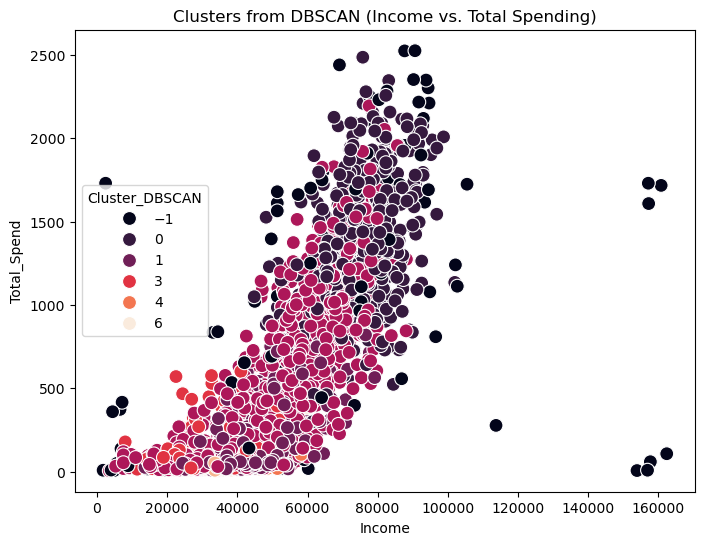

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='Total_Spend', hue='Cluster_DBSCAN', data=df_cust, palette='rocket', s=100)
plt.title('Clusters from DBSCAN (Income vs. Total Spending)')
plt.show()

## Agglomerative Clustering (Hierarchical Clustering)

In [37]:
agglomerative = AgglomerativeClustering(n_clusters=optimal_clusters)
df_cust['Cluster_Agglo'] = agglomerative.fit_predict(scaled_df)

silhouette_avg_agglo = silhouette_score(scaled_df, df_cust['Cluster_Agglo'])
db_score_agglo = davies_bouldin_score(scaled_df, df_cust['Cluster_Agglo'])
ch_score_agglo = calinski_harabasz_score(scaled_df, df_cust['Cluster_Agglo'])

print(f'Silhouette Score (Agglomerative): {silhouette_avg_agglo}')
print(f'Davies-Bouldin Index (Agglomerative): {db_score_agglo}')
print(f'Calinski-Harabasz Score (Agglomerative): {ch_score_agglo}')

Silhouette Score (Agglomerative): 0.2857470269390946
Davies-Bouldin Index (Agglomerative): 1.244370353466427
Calinski-Harabasz Score (Agglomerative): 1088.1101235127162


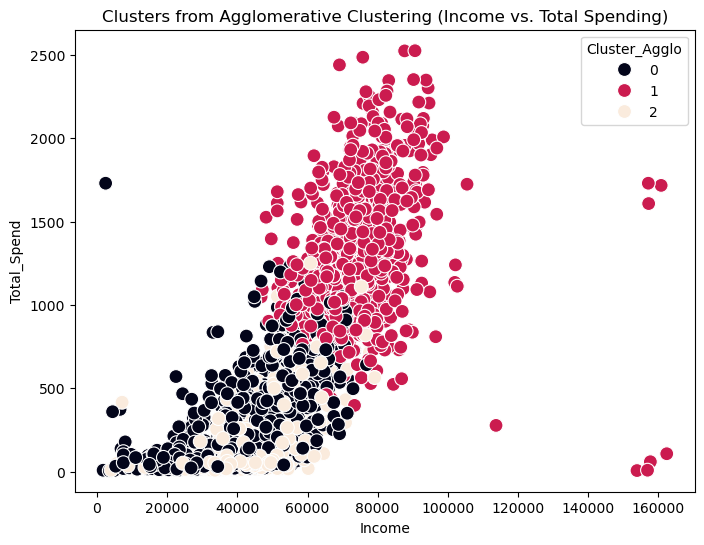

In [38]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='Total_Spend', hue='Cluster_Agglo', data=df_cust, palette='rocket', s=100)
plt.title('Clusters from Agglomerative Clustering (Income vs. Total Spending)')
plt.show()

## Gaussian Mixture Model

In [39]:
gmm = GaussianMixture(n_components=3, random_state=42)
df_cust['Cluster_GMM'] = gmm.fit_predict(scaled_df)

silhouette_avg_gmm = silhouette_score(scaled_df, df_cust['Cluster_GMM'])
db_score_gmm = davies_bouldin_score(scaled_df, df_cust['Cluster_GMM'])
ch_score_gmm = calinski_harabasz_score(scaled_df, df_cust['Cluster_GMM'])

print(f'Silhouette Score (GMM): {silhouette_avg_gmm}')
print(f'Davies-Bouldin Index (GMM): {db_score_gmm}')
print(f'Calinski-Harabasz Score (GMM): {ch_score_gmm}')

Silhouette Score (GMM): 0.18850126641012593
Davies-Bouldin Index (GMM): 1.9237885975336173
Calinski-Harabasz Score (GMM): 911.6625677713815


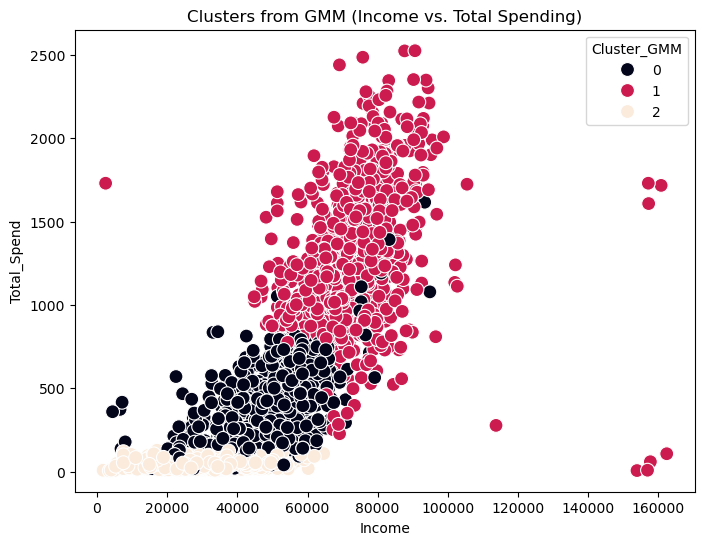

In [40]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Income', y='Total_Spend', hue='Cluster_GMM', data=df_cust, palette='rocket', s=100)
plt.title('Clusters from GMM (Income vs. Total Spending)')
plt.show()

# Customer segments from the clusters

In [41]:
cluster_summary = df_cust.groupby('Cluster_PCA').agg({
    'Income': ['mean', 'median'],
    'Total_Spend': ['mean', 'median'],
    'MntWines': 'mean',
    'MntMeatProducts': 'mean',
    'Marital_Status': lambda x: x.mode()[0],
    'Age': ['mean', 'median']
})

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
print(cluster_summary)

              Income_mean  Income_median  Total_Spend_mean  \
Cluster_PCA                                                  
0            33673.005867        33178.0        158.130378   
1            74108.897503        73113.0       1307.611038   
2            47940.647599        48952.5        337.016949   

             Total_Spend_median  MntWines_mean  MntMeatProducts_mean  \
Cluster_PCA                                                            
0                          70.0      65.606258             38.138201   
1                        1245.0     638.894875            392.145861   
2                         257.0     202.697740             64.548023   

             Marital_Status_<lambda>   Age_mean  Age_median  
Cluster_PCA                                                  
0                                  3  46.165580        47.0  
1                                  3  56.140604        55.0  
2                                  3  63.666667        64.0  


## Cluster Analysis

### Cluster 0 (Mid-Range Spenders):

Income: Mid-range income, with a mean of approximately 47,940 and a median of 48,952.

Total Spend: These customers are moderate spenders, with a mean total spend of 337 and a median of 257.

Wine and Meat Products: Moderate spenders on both wines (mean of 202) and meat products (mean of 64).

Marital Status: The most frequent marital status is 3 (representing 'Married' based on the dataset).

Age: This cluster is made up of older customers, with an average age of 63.7 years.

### Cluster 1 (Low Spenders, Younger):

Income: Low income, with a mean of approximately 33,734 and a median of 33,181.

Total Spend: These customers spend less, with a mean total spend of 159 and a median of 70.

Wine and Meat Products: Low spenders on wines (mean of 66) and meat products (mean of 38).

Marital Status: The most frequent marital status is 3 ('Married').

Age: This group consists of younger customers, with an average age of 46.2 years.

### Cluster 2 (High Spenders):

Income: High income, with a mean of approximately 74,153 and a median of 73,170.

Total Spend: These customers are the highest spenders, with a mean total spend of 1,308 and a median of 1,250.

Wine and Meat Products: Significant spending on both wines (mean of 639) and meat products (mean of 392).

Marital Status: The most frequent marital status is also 3 ('Married').

Age: The average age for this cluster is 56.2 years.

## Business Insights for Each Cluster

### Cluster 0 (Mid-Range Spenders):

#### Insights
These customers have mid-level incomes and spending patterns. They tend to be older, married individuals who spend moderately on wine and meat products. Marketing strategies could target value-for-money deals, loyalty programs, and practical product offerings.

#### Recommendation
Offer bundled deals that combine multiple products to increase average order value. Also, consider targeting them with practical, family-oriented promotions.

### Cluster 1 (Low Spenders, Younger):

#### Insights
Younger individuals with lower incomes, spending less on both wine and meat products. This group is likely more price-sensitive and may be more responsive to discounts and promotions.

#### Recommendation
Focus on entry-level products and price discounts. Digital marketing campaigns that resonate with younger, cost-conscious consumers may increase engagement.

### Cluster 2 (High Spenders):

#### Insights
These customers are affluent, high spenders, particularly on premium products like wine and meat. They are likely to respond well to premium offers and exclusive products.

#### Recommendation
Target them with high-end product promotions, VIP experiences, or personalized offers based on their purchase history. Exclusive events or loyalty programs could also boost engagement.


## Visualizations Cluster with boxplot

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_PCA', y='Income', data=df_cust, palette='rocket')
plt.title('Income Distribution Across Clusters')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_PCA', y='MntWines', data=df_cust, palette='rocket')
plt.title('Spending on Wines Across Clusters')
plt.show()

## Marketing recommandations

In [ ]:
# Calculate total campaigns accepted by cluster
df_cust['Total_Campaigns_Accepted'] = (df_cust['AcceptedCmp1'] + df_cust['AcceptedCmp2'] + 
                                       df_cust['AcceptedCmp3'] + df_cust['AcceptedCmp4'] + 
                                       df_cust['AcceptedCmp5'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Total_Campaigns_Accepted', hue='Cluster_PCA', data=df_cust, palette='rocket')
plt.title('Total Campaigns Accepted by Clusters')
plt.show()


## Marketing Recommendations:

### Cluster 0 (Mid-Range Spenders):

This group has moderate engagement with marketing campaigns. Campaigns offering a balance between value and quality will likely be effective for this group.
#### Recommendation: Continue offering value-based promotions, such as bundled deals or discounts on family-sized products.

### Cluster 1 (Low Spenders, Younger):

Minimal engagement with marketing campaigns, indicating a need for a different approach.
#### Recommendation: Offer targeted discounts on frequently purchased items and personalized emails to increase their campaign engagement.

### Cluster 2 (High Spenders):

This group shows higher engagement with marketing campaigns, accepting more offers than the other clusters.
#### Recommendation: Focus on personalized, high-end promotions. Introduce loyalty programs or exclusive offers that cater to their preferences, such as premium wine or gourmet food products.

## General Recommendations:

### Segmentation-Based Offers
Tailor your marketing campaigns based on the cluster segments. High spenders in Cluster 2 should receive premium offers, while Cluster 1 might need more incentives such as discounts or limited-time offers to increase engagement.

### Customer Retention Programs
For Cluster 0, consider creating retention-focused loyalty programs to increase their long-term value. Clusters 1 and 2 should focus on relationship-building and understanding their motivators to encourage more frequent purchases.

### Cross-Selling and Upselling
Focus on cross-selling opportunities for Cluster 2, as they are more likely to respond to high-value offers. For Clusters 1 and 0, consider upselling by offering higher-end versions of products they already buy.

### Refinement of Campaign Strategies
For lower-engagement clusters (1 and 0), perform A/B tests on messaging, offers, and delivery methods to better understand what resonates with these customers.